# PyDMD

## Tutorial 7: Descomposición en modo dinámico con control

En este tutorial mostraremos cómo extender la descomposición en modo dinámico para incorporar el efecto de control (esta técnica se introdujo en el artículo [Descomposición en modo dinámico con control] (https://arxiv.org/abs/1409.6358)).

Primero, importe la clase `DMDc` del paquete pyomo, configure matplotlib para el cuaderno e importe numpy y scipy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pydmd import DMDc
from pydmd.plotter import plot_eigs

Ahora creamos nuestro conjunto de datos: como queremos agregar el control, la evolución del sistema complejo se puede resumir formalmente como:
$$
\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k,
$$donde los operadores $\mathbf{A}$ y $\mathbf{B}$ son los que aproximaremos usando DMD. Entonces, con fines demostrativos, creamos las instantáneas originales utilizando dos operadores aleatorios.

In [2]:
def create_system(n, m):
    # Generar una matriz de Helmert cuadrada (n)
    A = scipy.linalg.helmert(n, True)
    # Crear una matriz de dimension (nxn)
    B = np.random.rand(n, n) - 0.5
    # 0,25 repetido n veces en un array 
    x0 = np.array([0.25] * n)

    u = np.random.rand(n, m - 1) - 0.5
    
    snapshots = [x0]

    for i in range(m - 1):
        snapshots.append(A.dot(snapshots[i]) + B.dot(u[:, i]))

    snapshots = np.array(snapshots).T
    return {"snapshots": snapshots, "u": u, "B": B, "A": A}

Obtuvimos 10 instantáneas del sistema en evolución

In [3]:
s = create_system(25, 10)
print(s["snapshots"].shape)

(25, 10)


Ahora, podemos calcular como de costumbre el algoritmo DMD sobre los datos: el método `fit` en esta versión toma como argumentos las instantáneas y la entrada de control (también se puede pasar el operador $\mathbf{B}$). En este caso, no realizamos ningún truncamiento.

In [4]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(s["snapshots"], s["u"])

Visualicemos el sistema original y el reconstruido: ¡también porque sin truncamiento, las gráficas son las mismas!

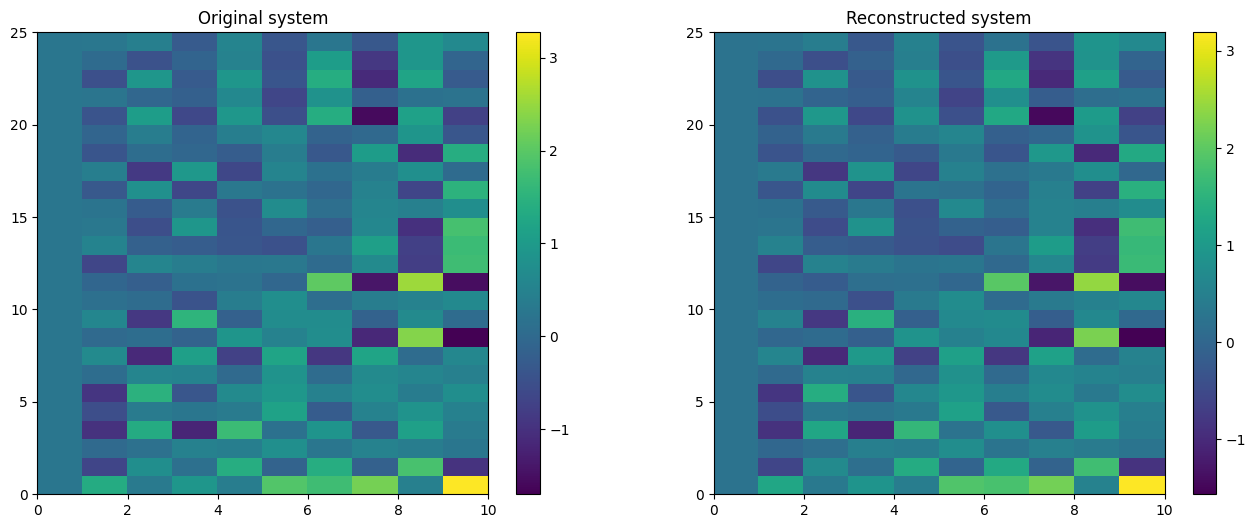

In [5]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Original system")
plt.pcolor(s["snapshots"].real)
plt.colorbar()

plt.subplot(122)
plt.title("Reconstructed system")
plt.pcolor(dmdc.reconstructed_data().real)
plt.colorbar()

plt.show()

Bueno, construimos la aproximación para $\mathbf{A}$ y para $\mathbf{B}$; Ahora podemos probar el sistema con una entrada de control diferente: a diferencia de las otras versiones, podemos pasar como argumento del método `reconstructed_data` la entrada de control que queremos probar.

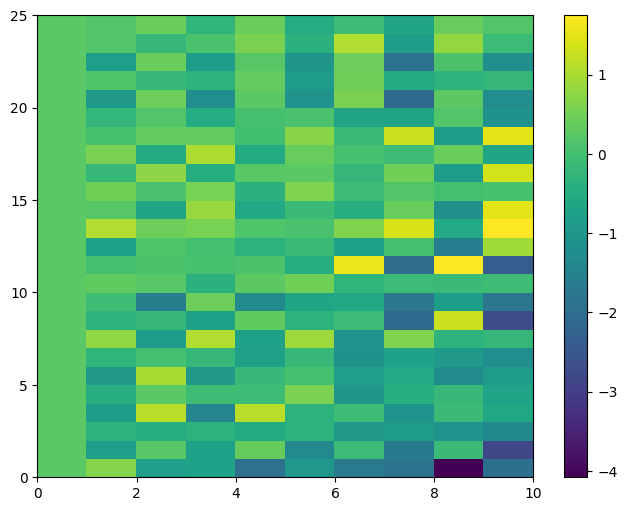

In [6]:
new_u = np.exp(s["u"])

plt.figure(figsize=(8, 6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()

Finalmente, también podemos usar un paso de tiempo diferente para la reconstrucción, obviamente pasando la entrada de control adecuada (la cantidad de entradas que pasamos tiene que ser la cantidad de instantáneas reconstruidas que intentamos calcular, excepto las primeras instantáneas). Continuamos reduciendo a la mitad el paso de tiempo y creamos una nueva entrada aleatoria.

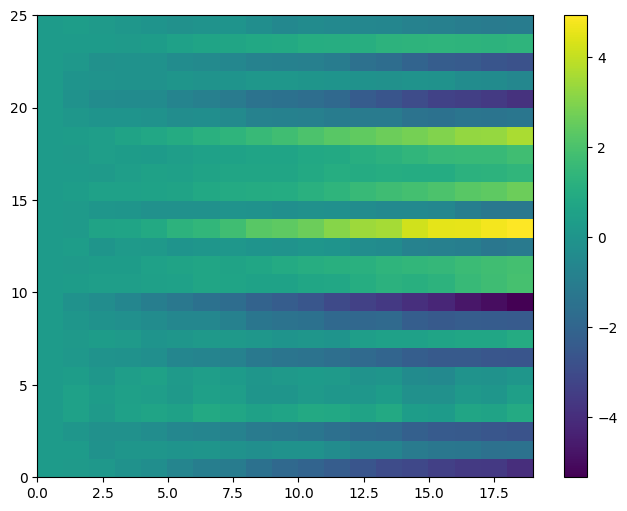

In [7]:
dmdc.dmd_time["dt"] = 0.5
new_u = np.random.rand(s["u"].shape[0], dmdc.dynamics.shape[1] - 1)

plt.figure(figsize=(8, 6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()

## Recuperando dinámicas inestables

En esta subsección del tutorial "DMDc" vamos a investigar el efecto estabilizador del control en un sistema lineal inestable. Por simplicidad, consideramos un sistema 3D con un operador "B" conocido. Este tutorial está inspirado en el "Ejemplo 1" del artículo [Descomposición en modo dinámico con control] (https://arxiv.org/abs/1409.6358).

In [8]:
time_instants = 5

A = np.array([[2.1, 0, 0], [0, 0.5, 0], [0, 0, 6.9]])
B = np.array([1.3, 0, 3])[:, None] * 2

snapshots = np.zeros((3, time_instants))
snapshots[:, 0] = np.array([5, 6, 3])

Construimos nuestra matriz de instantáneas usando la fórmula habitual: $\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k$, donde ` A`,`B` se especifican arriba y $\mathbf{u}_k = -\mathbf{x}_k$.

In [9]:
for i in range(1, time_instants):
    previous_snapshot = snapshots[:, i - 1][:, None]
    snapshots[:, i] = (
        A.dot(previous_snapshot) - B * previous_snapshot
    ).flatten()
print(snapshots)

[[ 5.     -2.5     1.25   -0.625   0.3125]
 [ 6.      3.      1.5     0.75    0.375 ]
 [ 3.      2.7     2.43    2.187   1.9683]]


Construimos la matriz de entrada de control utilizada en la fórmula para enviarla al constructor `DMDc`:

In [10]:
I = -snapshots[:, :-1]
print(I)

dmdc = DMDc(svd_rank=-1).fit(snapshots, I, np.diag(B.flatten()))

[[-5.     2.5   -1.25   0.625]
 [-6.    -3.    -1.5   -0.75 ]
 [-3.    -2.7   -2.43  -2.187]]


Ahora pausamos `DMDc` por un momento, y analizamos el sistema resultante del conjunto de instantáneas, como si no supiéramos que es un sistema de control. Por lo tanto, utilizamos el algoritmo DMD estándar y luego trazamos los valores propios para evaluar la estabilidad de su dinámica.

C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(


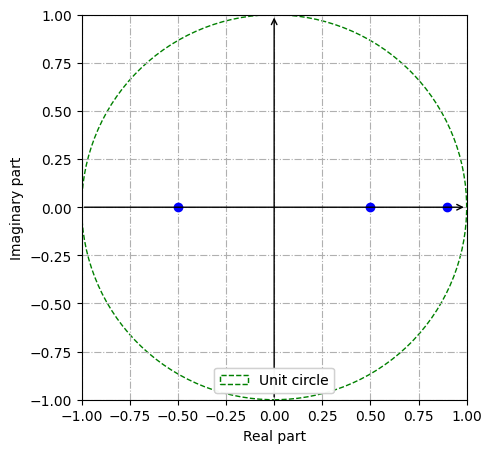

In [11]:
from pydmd import DMD

dmd = DMD(svd_rank=-1)
dmd.fit(snapshots)
plot_eigs(
    dmd,
    show_axes=True,
    show_unit_circle=True,
    figsize=(5, 5),
    filename="eigs_ex1.pdf",
)

Como podemos ver, todos los valores propios están dentro de la esfera unitaria, por lo tanto, las dinámicas correspondientes son todas estables.

Por el contrario, si usamos DMD con control vemos que hay algunas dinámicas inestables en el operador `A` "real", que perdemos cuando usamos el algoritmo original, pero que se recuperan si empleamos el modificado.

C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(


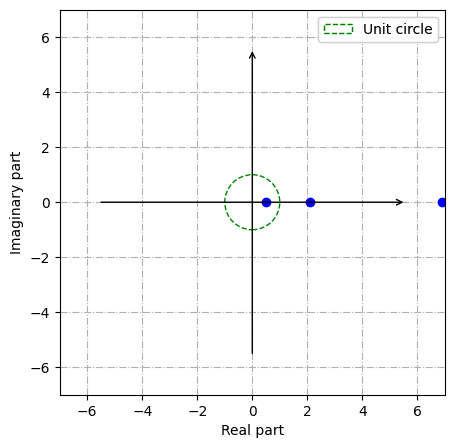

Eigenvalue 6.900000000000041: distance from unit circle 5.900000000000041
Eigenvalue 0.49999999999999845: distance from unit circle 0.5000000000000016
Eigenvalue 2.0999999999999948: distance from unit circle 1.0999999999999948


In [12]:
plot_eigs(dmdc, show_axes=True, show_unit_circle=True, figsize=(5, 5))

for eig in dmdc.eigs:
    print(
        "Eigenvalue {}: distance from unit circle {}".format(
            eig, np.abs(1 - np.linalg.norm(eig))
        )
    )

Buscamos una confirmación de este hecho calculando los valores propios del operador `A` que usamos cuando construimos el sistema, y ​​los comparamos con los valores propios de `dmd.atilde` que contiene la aproximación de `A ` construido por DMD con control.

In [13]:
print(
    "Eigenvalues of A:",
    np.linalg.eigvals(A),
    "; eigenvalues of A_tilde: ",
    np.linalg.eigvals(dmdc.operator.as_numpy_array),
)

Eigenvalues of A: [2.1 0.5 6.9] ; eigenvalues of A_tilde:  [6.9 0.5 2.1]
